In [2]:
# Notebook pour la description de la composition des clusters

# Library ----------------------------------------------------------------
library(dplyr)
library(tidyr)
library(ggplot2)
library(sondr)
library(clessnize)
library(ggtext)
library(tidytext)
library(ellipsellm)

# Charger les données et le résultat du clustering
kmeans_result <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_kmeans.rds")
df_pilot1_2022 <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_2022.rds")

# Sélectionner les variables utilisées pour le clustering (exclure "id" et les colonnes commençant par "cluster")
variablesUsedForClustering <- names(df_pilot1_2022)[ !grepl("^cluster|^id$", names(df_pilot1_2022)) ]

# Créer une dataframe enrichie avec la variable cluster convertie en facteur
dfUsedForClustering <- df_pilot1_2022
dfUsedForClustering$cluster <- as.factor(kmeans_result$cluster)

# Définir le chemin de sauvegarde des graphiques
output_path <- "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022"


In [3]:
# Fonction pour calculer l'importance relative de chaque variable 
# dans la création des clusters -----------------------------

# Fonction pour calculer l'importance relative des variables dans le clustering
calculate_importance <- function(data, variables) {
  importance_scores <- sapply(variables, function(var) {
    overall_mean <- mean(data[[var]], na.rm = TRUE)
    cluster_means <- tapply(data[[var]], data$cluster, mean, na.rm = TRUE)
    abs_diff <- abs(cluster_means - overall_mean) / sd(data[[var]], na.rm = TRUE)
    return(mean(abs_diff, na.rm = TRUE))
  })
  importance_scores <- importance_scores / sum(importance_scores)  # Normaliser
  return(importance_scores)
}


In [4]:
# Fonction pour décrire les personas en affichant les moyennes et écarts-types par cluster
# (La variable "cluster" doit déjà être présente et factorisée dans data)
describe_personas <- function(data, variables) {
  persona_summary <- data %>%
    group_by(cluster) %>%
    summarise(across(all_of(variables), list(mean = ~mean(.x, na.rm = TRUE),
                                               sd = ~sd(.x, na.rm = TRUE))))
  print(persona_summary)
}

In [5]:
# Calcul du score d'importance relatif pour chaque variable
importance_scores <- calculate_importance(dfUsedForClustering, variablesUsedForClustering)
print(importance_scores)

# Afficher les statistiques descriptives par cluster
describe_personas(dfUsedForClustering, variablesUsedForClustering)

                           act_Gym                           act_Walk 
                       0.005008155                        0.004056627 
                           act_Run                           act_Yoga 
                       0.005328324                        0.007004296 
                         act_Other                           act_None 
                       0.005099301                        0.005206139 
                       act_Fishing                        act_Hunting 
                       0.011466852                        0.011247054 
         act_VisitsMuseumsGaleries     act_MotorizedOutdoorActivities 
                       0.008736669                        0.010080291 
                  act_Volunteering                 app_swag_Classique 
                       0.009573212                        0.004288048 
                   app_swag_Casual                     app_swag_Sport 
                       0.002503146                        0.005885807 
      

# A tibble: 6 × 155
  cluster act_Gym_mean act_Gym_sd act_Walk_mean act_Walk_sd act_Run_mean
  <fct>          <dbl>      <dbl>         <dbl>       <dbl>        <dbl>
1 1             0.127       0.334         0.639       0.481       0.0837
2 2             0.139       0.346         0.589       0.493       0.0977
3 3             0.0829      0.276         0.707       0.456       0.0442
4 4             0.185       0.390         0.669       0.472       0.169 
5 5             0.158       0.366         0.633       0.484       0.0935
6 6             0.109       0.313         0.606       0.490       0.0848
# A tibble: 6 × 155
  cluster act_Gym_mean act_Gym_sd act_Walk_mean act_Walk_sd act_Run_mean
  <fct>          <dbl>      <dbl>         <dbl>       <dbl>        <dbl>
1 1             0.127       0.334         0.639       0.481       0.0837
2 2             0.139       0.346         0.589       0.493       0.0977
3 3             0.0829      0.276         0.707       0.456       0.0442
4 4        

# ℹ 149 more variables: act_Run_sd <dbl>, act_Yoga_mean <dbl>,
#   act_Yoga_sd <dbl>, act_Other_mean <dbl>, act_Other_sd <dbl>,
#   act_None_mean <dbl>, act_None_sd <dbl>, act_Fishing_mean <dbl>,
#   act_Fishing_sd <dbl>, act_Hunting_mean <dbl>, act_Hunting_sd <dbl>,
#   act_VisitsMuseumsGaleries_mean <dbl>, act_VisitsMuseumsGaleries_sd <dbl>,
#   act_MotorizedOutdoorActivities_mean <dbl>,
#   act_MotorizedOutdoorActivities_sd <dbl>, act_Volunteering_mean <dbl>, …
# ℹ Use `colnames()` to see all variable names
# ℹ 149 more variables: act_Run_sd <dbl>, act_Yoga_mean <dbl>,
#   act_Yoga_sd <dbl>, act_Other_mean <dbl>, act_Other_sd <dbl>,
#   act_None_mean <dbl>, act_None_sd <dbl>, act_Fishing_mean <dbl>,
#   act_Fishing_sd <dbl>, act_Hunting_mean <dbl>, act_Hunting_sd <dbl>,
#   act_VisitsMuseumsGaleries_mean <dbl>, act_VisitsMuseumsGaleries_sd <dbl>,
#   act_MotorizedOutdoorActivities_mean <dbl>,
#   act_MotorizedOutdoorActivities_sd <dbl>, act_Volunteering_mean <dbl>, …
# ℹ Use `colnam

In [8]:
# Initialiser une liste pour stocker tous les prompts
# Initialiser une liste pour stocker tous les prompts
prompts <- list()
all_data_viz <- data.frame()

for (cluster_value in levels(dfUsedForClustering$cluster)) {
  # Extraire les données du cluster
  cluster_data <- dfUsedForClustering %>% filter(cluster == cluster_value)
  
  # Calculer les moyennes par variable pour le cluster et globalement
  means <- sapply(variablesUsedForClustering, function(var) mean(cluster_data[[var]], na.rm = TRUE))
  overall_means <- sapply(variablesUsedForClustering, function(var) mean(dfUsedForClustering[[var]], na.rm = TRUE))
  
  # Identification des caractéristiques marquantes
  characteristic_vars <- sapply(variablesUsedForClustering, function(var) {
    if (all(dfUsedForClustering[[var]] %in% c(0, 1))) {
      prop_cluster <- mean(cluster_data[[var]], na.rm = TRUE)
      prop_overall <- mean(dfUsedForClustering[[var]], na.rm = TRUE)
      p_value <- prop.test(x = c(sum(cluster_data[[var]]), sum(dfUsedForClustering[[var]])),
                           n = c(nrow(cluster_data), nrow(dfUsedForClustering)))$p.value
      prop_diff <- abs(prop_cluster - prop_overall)
      if (p_value < 0.05 && prop_diff > 0.3) {
        return(ifelse(prop_cluster > prop_overall, "green", "red"))
      } else {
        return("black")
      }
    } else {
      t_test <- t.test(cluster_data[[var]], dfUsedForClustering[[var]])
      effect_size <- abs(t_test$estimate[1] - t_test$estimate[2]) / sd(dfUsedForClustering[[var]], na.rm = TRUE)
      if (t_test$p.value < 0.05 && effect_size > 0.25) {
        return(ifelse(t_test$estimate[1] > t_test$estimate[2], "green", "red"))
      } else {
        return("black")
      }
    }
  })
  
  # Calculer quelques statistiques démographiques pour le cluster
  perc_femmes     <- mean(cluster_data$female, na.rm = TRUE) * 100
  perc_immigrants <- mean(cluster_data$immigrant, na.rm = TRUE) * 100
  perc_langEn     <- mean(cluster_data$langEn, na.rm = TRUE) * 100
  perc_langFr     <- mean(cluster_data$langFr, na.rm = TRUE) * 100
  perc_ses_languageOther <- mean(cluster_data$ses_languageOther, na.rm = TRUE) * 100
  perc_ethn_white <- mean(cluster_data$ses_ethn_White, na.rm = TRUE) * 100
  perc_hetero     <- mean(cluster_data$ses_hetero, na.rm = TRUE) * 100
  educ_mean       <- mean(cluster_data$educ, na.rm = TRUE)
  age_mean        <- mean(cluster_data$age, na.rm = TRUE)
  revenu_moyen    <- mean(cluster_data$ses_income, na.rm = TRUE)
  
  # Générer le prompt de suggestion de nom pour ce cluster
  prompt_description <- paste0(
    "Persona ", cluster_value, ":\n",
    "Sup: ", if (any(characteristic_vars == "green")) {
      paste(variablesUsedForClustering[characteristic_vars == "green"], collapse = ", ")
    } else {
      "Aucune"
    }, "\n",
    "Inf: ", if (any(characteristic_vars == "red")) {
      paste(variablesUsedForClustering[characteristic_vars == "red"], collapse = ", ")
    } else {
      "Aucune"
    }, "\n",
    "Femmes: ", round(perc_femmes, 1), "%, Immigrants: ", round(perc_immigrants, 1), "%\n",
    "Âge: ", round(age_mean, 1), " ans, Revenu: ", round(revenu_moyen, 1), " k$\n",
    "Langues: En ", round(perc_langEn, 1), "%, Fr ", round(perc_langFr, 1), "%, Autres: ", round(perc_ses_languageOther, 1), "%\n",
    "Édu: ", round(educ_mean, 1), " (0=bas, 1=élevé), Ethnie (Blanc): ", round(perc_ethn_white, 1), "%\n",
    "Orientation (Hétéro): ", round(perc_hetero, 1), "%\n",
    "Proposez un nom (ex: Prénom: Descriptif) et une description courte."
  )
  
  # Stocker le prompt dans la liste
  prompts[[cluster_value]] <- prompt_description
  
  # Préparer les données pour le graphique (si besoin)
  data_viz <- data.frame(
    Variable = variablesUsedForClustering, 
    Mean = means, 
    Overall = overall_means, 
    Cluster = cluster_value,
    Color = characteristic_vars,
    Persona = paste("Persona", cluster_value)
  )
  all_data_viz <- rbind(all_data_viz, data_viz)
}


There were 30 warnings (use warnings() to see them)


In [9]:
# Afficher ou traiter tous les prompts
for (cluster in names(prompts)) {
  print(paste("===== Prompt pour le cluster", cluster, "====="))
  print(prompts[[cluster]])
  
  # Par exemple, envoyer chaque prompt à OpenAI (si la fonction est correctement définie)
  conv <- openai_create_conversation(prompts[[cluster]])
  resp <- openai_chat_completion(conv)
  print(paste0("Réponse pour le cluster ", cluster, " :"))
  print(resp$content)
}

[1] "===== Prompt pour le cluster 1 ====="
[1] "Persona 1:\nSup: female\nInf: male\nFemmes: 99.8%, Immigrants: 4.6%\nÂge: 0.6 ans, Revenu: 0.4 k$\nLangues: En 11.2%, Fr 88.8%, Autres: 0%\nÉdu: 0.5 (0=bas, 1=élevé), Ethnie (Blanc): 99%\nOrientation (Hétéro): 100%\nProposez un nom (ex: Prénom: Descriptif) et une description courte."
[1] "===== Prompt pour le cluster 1 ====="
[1] "Persona 1:\nSup: female\nInf: male\nFemmes: 99.8%, Immigrants: 4.6%\nÂge: 0.6 ans, Revenu: 0.4 k$\nLangues: En 11.2%, Fr 88.8%, Autres: 0%\nÉdu: 0.5 (0=bas, 1=élevé), Ethnie (Blanc): 99%\nOrientation (Hétéro): 100%\nProposez un nom (ex: Prénom: Descriptif) et une description courte."


[1] "Réponse pour le cluster 1 :"
[1] "Prénom: Chloé La Francophone\n\nChloé La Francophone est une jeune femme francophone vivant dans un milieu principalement blanc et homogène. Elle a un très jeune âge, avec un revenu et un niveau d'éducation relativement bas. Avec un environnement enrichi presque exclusivement par la langue française, elle a une perspective culturelle fortement influencée par ses origines. Sa communauté présente un faible taux d'immigration, ce qui contribue à sa vision du monde principalement locale et traditionnelle. Son orientation hétérosexuelle est une caractéristique importante de son identité personnelle."
[1] "===== Prompt pour le cluster 2 ====="
[1] "Persona 2:\nSup: male\nInf: female\nFemmes: 0.5%, Immigrants: 6.4%\nÂge: 0.7 ans, Revenu: 0.4 k$\nLangues: En 13.4%, Fr 86.6%, Autres: 0%\nÉdu: 0.6 (0=bas, 1=élevé), Ethnie (Blanc): 98.7%\nOrientation (Hétéro): 100%\nProposez un nom (ex: Prénom: Descriptif) et une description courte."
[1] "Réponse pour le clu

[1] "Réponse pour le cluster 2 :"
[1] "Prénom: Paul - Le Jeune Provincial\n\nDescription courte: Paul est un jeune homme d'à peine 8 mois, vivant dans une région francophone. Il fait partie d'une communauté principalement blanche et francophone, avec une très faible représentation féminine et peu d'immigrants. Son environnement est majoritairement rural, avec un niveau d'éducation bas et des revenus modestes. Paul est élevé dans une culture hétérocentrée et développe ses premiers balbutiements dans un monde où le français est la langue dominante."
[1] "===== Prompt pour le cluster 3 ====="
[1] "Persona 3:\nSup: act_transport_Walk, vehicule_noCar, ses_income_i1to30\nInf: act_MotorizedOutdoorActivities, cons_Meat, ses_dwelling_detachedHouse, act_transport_Car, vehicule_Voiture, ses_income\nFemmes: 60.2%, Immigrants: 12.2%\nÂge: 0.6 ans, Revenu: 0.2 k$\nLangues: En 16.6%, Fr 83.4%, Autres: 0%\nÉdu: 0.5 (0=bas, 1=élevé), Ethnie (Blanc): 94.5%\nOrientation (Hétéro): 98.9%\nProposez un nom (

[1] "Réponse pour le cluster 3 :"
[1] "**Nom : Camille : L'Aventurière Locale**\n\nCamille est une jeune femme de 0.6 ans, vivant dans une maison individuelle et appréciant particulièrement les activités de plein air motorisées. Bien que ses revenus soient modestes, elle profite d'un mode de vie simple, privilégiant les déplacements à pied. Elle parle principalement français, tout en ayant une connaissance de l'anglais. Camille appartient majoritairement à l'ethnie blanche et s'identifie comme hétérosexuelle. Son éducation est au niveau intermédiaire. Malgré ses ressources limitées, elle apprécie la viande dans son alimentation et rêve d'un avenir où elle pourra conduire une voiture."
[1] "===== Prompt pour le cluster 4 ====="
[1] "Persona 4:\nSup: act_VisitsMuseumsGaleries, act_Volunteering, immigrant, educ\nInf: langFr, ses_ethn_White, age\nFemmes: 47.6%, Immigrants: 73.4%\nÂge: 0.4 ans, Revenu: 0.4 k$\nLangues: En 28.2%, Fr 42.7%, Autres: 29%\nÉdu: 0.8 (0=bas, 1=élevé), Ethnie (Blan

[1] "Réponse pour le cluster 4 :"
[1] "Nom : Lucie la Curieuse\n\nDescription : Lucie est une femme dynamique et ouverte d'esprit, passionnée par l'art et la culture. Immigrante dans un pays francophone, elle se consacre activement à visiter des musées et galeries, et participe régulièrement à des activités bénévoles pour mieux s'intégrer et contribuer à sa communauté. Bien qu'elle soit jeune avec un revenu modeste, son niveau d'éducation est élevé, ce qui lui permet de naviguer avec aisance dans différentes cultures. Elle parle couramment le français, sa langue principale, tout en étant entourée d'une communauté diversifiée. Lucie valorise les échanges interculturels et incarne la diversité avec sa perspective unique et son enthousiasme pour l'apprentissage continu."
[1] "===== Prompt pour le cluster 5 ====="
[1] "Persona 5:\nSup: act_VisitsMuseumsGaleries, ses_gai, ses_bisex\nInf: ses_hetero, age\nFemmes: 36.7%, Immigrants: 14.4%\nÂge: 0.5 ans, Revenu: 0.4 k$\nLangues: En 18%, Fr 82%

[1] "Réponse pour le cluster 5 :"
[1] "Prénom: Alex - L'Aventurier Culturel\n\nDescription: Alex est une personne curieuse et ouverte d'esprit, passionnée par l'exploration des musées et galeries d'art. Avec une orientation sexuelle diversifiée (gai ou bisexuel) et une éducation relativement élevée, Alex apprécie la richesse culturelle et les différentes perspectives que ces lieux offrent. Bien qu'Alex soit jeune, avec une moyenne d'âge de seulement 0.5 ans et une prédominance de la langue française, cette personne appartient à une communauté majoritairement blanche. Alex est également sensible aux questions d'immigration, avec 14.4% de ses pairs étant issus de l'immigration. Sa vie est marquée par la curiosité et l'exploration culturelle, enrichissant ses interactions quotidiennes et son cercle social."
[1] "===== Prompt pour le cluster 6 ====="
[1] "Persona 6:\nSup: act_Fishing, act_Hunting, act_MotorizedOutdoorActivities, act_transport_SUV, vehicule_VUS, ses_income\nInf: act_transpo

[1] "Réponse pour le cluster 6 :"
[1] "Prénom: Luc - Le Passionné de Plein Air\n\nDescription: Luc est un passionné des activités en plein air, surtout celles qui nécessitent un peu de moteur. Il aime la pêche, la chasse et se déplace souvent en SUV pour explorer la nature. Élevé dans un environnement francophone, il vit dans une communauté où les traditions sont chères et les racines culturelles profondes. Malgré un revenu modeste, il investit dans ses passions et apprécie la simplicité que la vie en extérieur lui offre. Luc représente une personne ancrée dans ses habitudes, valorisant sa culture et son mode de vie actif."
[1] "Réponse pour le cluster 6 :"
[1] "Prénom: Luc - Le Passionné de Plein Air\n\nDescription: Luc est un passionné des activités en plein air, surtout celles qui nécessitent un peu de moteur. Il aime la pêche, la chasse et se déplace souvent en SUV pour explorer la nature. Élevé dans un environnement francophone, il vit dans une communauté où les traditions sont ch

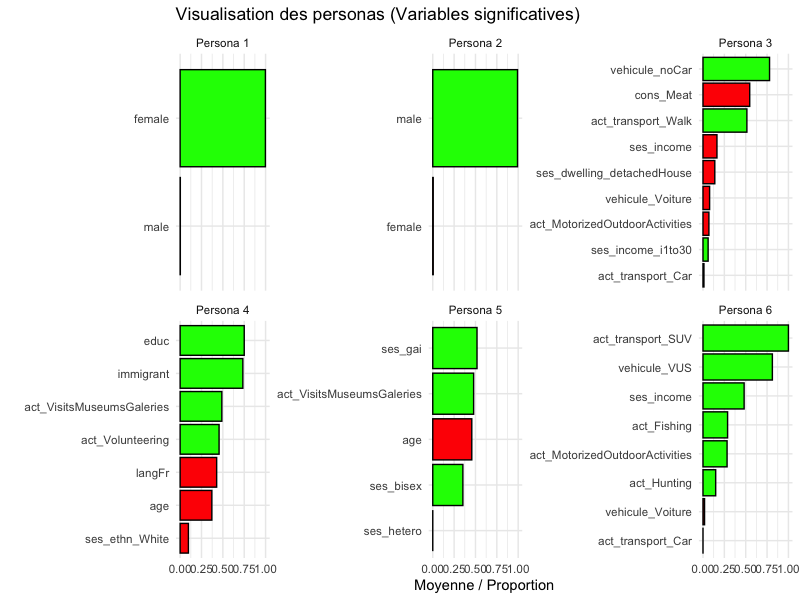

In [10]:
all_data_viz_signif <- all_data_viz %>%
  filter(Color %in% c("green", "red"))

ggplot(all_data_viz_signif, aes(x = reorder_within(Variable, Mean, Persona), 
                                y = Mean, fill = Color)) +
  geom_bar(stat = "identity", color = "black", show.legend = FALSE) +
  scale_fill_identity() +
  labs(title = "Visualisation des personas (Variables significatives)", x = "", y = "Moyenne / Proportion") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~ Persona, scales = "free_y") +
  scale_x_reordered()